In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from state_cleaner import *
from datetime import datetime
import requests
import json

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
os.chdir('../..')
os.chdir('CovidMobile')
os.getcwd()

'C:\\Users\\Noah\\CovidMobile'

# SafeGraph Data

In [3]:
df = pd.read_csv('data/safegraph_data_2020-05-21.csv')
df['state_abb'] = df['state'].copy()
df['state'] = df['state_abb'].apply(replace_acronym).copy()
df[['FIPS','state','state_abb','county']]
df['date'] = pd.to_datetime(df['date'],errors='coerce')
df = df[df['state'].notnull()]

In [4]:
df[df['county'].isnull()].shape

(0, 34)

# Build Dataset

In [5]:
os.getcwd()

'C:\\Users\\Noah\\CovidMobile'

In [6]:
full = pd.read_csv('data/Global_Mobility_Report.csv')
full['source'] = 'google'

full.rename(columns={'transit_stations_percent_change_from_baseline':'transit',
                 'residential_percent_change_from_baseline':'homes',
                 'grocery_and_pharmacy_percent_change_from_baseline':'food_drugs',
                'retail_and_recreation_percent_change_from_baseline':'retail',
                'workplaces_percent_change_from_baseline':'work',
                'parks_percent_change_from_baseline':'park'},inplace=True)


C:\Users\Noah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
full.columns.values

array(['country_region_code', 'country_region', 'sub_region_1',
       'sub_region_2', 'date', 'retail', 'food_drugs', 'park', 'transit',
       'work', 'homes', 'source'], dtype=object)

In [8]:
full = full[full['country_region_code']=='US'].rename(columns={'sub_region_1':'state','sub_region_2':'county'}) 

In [9]:
full['state_abb'] = full['state'].apply(replace_acronym)
full['county'] = np.where(full['county'].isnull(),full['state_abb'] ,full['county'] )

In [10]:
full.tail()

,country_region_code,country_region,state,county,date,retail,food_drugs,park,transit,work,homes,source,state_abb
359324,US,United States,Wyoming,Weston County,2020-05-11,NaN,NaN,NaN,NaN,-31.0,NaN,google,WY
359325,US,United States,Wyoming,Weston County,2020-05-12,NaN,NaN,NaN,NaN,-34.0,NaN,google,WY
359326,US,United States,Wyoming,Weston County,2020-05-13,NaN,NaN,NaN,NaN,-30.0,NaN,google,WY
359327,US,United States,Wyoming,Weston County,2020-05-14,NaN,NaN,NaN,NaN,-25.0,NaN,google,WY
359328,US,United States,Wyoming,Weston County,2020-05-15,NaN,NaN,NaN,NaN,-25.0,NaN,google,WY


In [11]:
replc_county = {'Anchorage' :'Anchorage Municipality',
'Bethel' :'Bethel Census Area',
'Fairbanks North Star' :'Fairbanks North Star Borough',
'Juneau' : 'Juneau City and Borough',
'Kenai Peninsula Borough' :'Kenai Peninsula Borough',
'Ketchikan Gateway' :'Ketchikan Gateway Borough',
'Kodiak Island':'Kodiak Island Borough',
'Matanuska-Susitna':'Matanuska-Susitna Borough',
'North Slope':'North Slope Borough',
'Sitka':'Sitka City and Borough',
'Southeast Fairbanks':'Southeast Fairbanks Census Area',
'Valdez-Cordova':'Valdez-Cordova Census Area',
'Doña Ana County':'Dona Ana County',
'DC':'District of Columbia'}

citys = ['Staunton',
'Norfolk',
'Baltimore',
'Newport News', 
'Fairfax',
'Martinsville',
'Waynesboro', 
'Colonial Heights',
'St. Louis',
'Salem',
'Harrisonburg',
'Bristol',
'Chesapeake',
'Portsmouth',
'Virginia Beach',
'Manassas Park',
'Williamsburg',
'Radford',
'Charlottesville',
'Manassas',

'Alexandria',
'Hampton',
'Fredericksburg',
'Richmond',
'Hopewell',
'Petersburg',
'Roanoke',
'Suffolk',
'Lynchburg',
'Danville',
'Falls Church',
'Winchester', 
'Franklin',
'Emporia',
'Galax',
'Poquoson',
'Covington',
'Buena Vista',
'Norton',
'Lexington']

In [12]:
replc_county = {**replc_county, **{ i:'{} city'.format(i) for i in citys}}
full['county'] = full['county'].replace(replc_county)

In [13]:

full_tog = full.merge(df[['FIPS','state_abb','county']].drop_duplicates(),on=['state_abb','county'],how='left')

In [14]:
full_tog.date = pd.to_datetime(full_tog.date,errors='coerce') 
print(df.shape)
full_tog = df.merge(full_tog[['FIPS','date','retail','food_drugs','park','transit','work','homes']],on=['FIPS','date'],how='left')
print(full_tog.shape)

(299197, 34)
(299197, 40)


# USDA

In [15]:
files = ["Education.csv",
"PopulationEstimates.csv",
"PovertyEstimates.csv",
"Unemployment.csv"]

for i,f in enumerate(files):
    df =pd.read_csv('data/{}'.format(f))
    print(df.columns[0])
    df.rename(columns={df.columns[0]:'FIPS'},inplace=True)
    if i ==0:
        usda = df.copy()
        continue
    else:
        usda = usda.merge(df,on=['FIPS'])

FIPS Code
FIPStxt
FIPStxt
FIPStxt


In [16]:
usda = pd.concat([usda['FIPS'],usda.filter(like='2018')],axis=1)

In [17]:
full_tog = full_tog.merge(usda,on='FIPS',how='left') 

#### Second CSV File

In [18]:
usda_full = pd.read_excel('./data/food_env_atlas_usda.xls', sheet_name = None)
sheet_names = usda_full.keys()
sheets2keep = ['ACCESS','STORES','RESTAURANTS','ASSISTANCE','INSECURITY']

usda2 = usda_full['Supplemental Data - County']
usda2.rename(columns={'FIPS ': 'FIPS'},inplace=True)
#convert populations from string to numbers:
for col in usda2.iloc[:,3:]:
    usda2[col] = [int(x.replace(',' , '')) for x in usda2[col]]

#add other helpful data
for sheet_name in sheets2keep:
    print(sheet_name)
    usda2 = pd.merge(usda2, usda_full[sheet_name], on = 'FIPS', how = 'left')

ACCESS
STORES
RESTAURANTS
ASSISTANCE
INSECURITY


In [19]:
#get rid of duplicate State and County data:
usda2.iloc[:,~usda2.columns.duplicated()]

#export to cleaned csv:
usda2.to_csv('./data/clean_usda2.csv')

# Neighboring Counties

In [20]:
def keep_one(tup):
    col = tup[1]
    if col == '':
        col = tup[0]
    return col

In [21]:
neighbors = pd.read_csv('data/county_adjacency.csv')

neighbors = neighbors[neighbors['FIPS']!=neighbors['nearby_FIPS']]
neighbors['count'] = neighbors.groupby(['FIPS','county']).cumcount()
neighbors =neighbors.pivot(index='FIPS',columns='count',values='nearby_FIPS')
neighbors =neighbors.reset_index()
print(neighbors.head())
neighbors.columns = ['FIPS', 'neighbors1', 'neighbors2', 'neighbors3', 'neighbors4', 'neighbors5', 'neighbors6', 'neighbors7', 'neighbors8', 'neighbors9', 'neighbors10', 'neighbors11', 'neighbors12','neighbors13','neighbors14']

count    FIPS       0       1       2       3       4        5        6  \
0      1001.0  1021.0  1047.0  1051.0  1085.0  1101.0      NaN      NaN   
1      1003.0  1025.0  1053.0  1097.0  1099.0  1129.0  12033.0      NaN   
2      1005.0  1011.0  1045.0  1067.0  1109.0  1113.0  13061.0  13239.0   
3      1007.0  1021.0  1065.0  1073.0  1105.0  1117.0   1125.0      NaN   
4      1009.0  1043.0  1055.0  1073.0  1095.0  1115.0   1127.0      NaN   

count        7   8   9  10  11  12  13  
0          NaN NaN NaN NaN NaN NaN NaN  
1          NaN NaN NaN NaN NaN NaN NaN  
2      13259.0 NaN NaN NaN NaN NaN NaN  
3          NaN NaN NaN NaN NaN NaN NaN  
4          NaN NaN NaN NaN NaN NaN NaN  


In [22]:
neighbors[neighbors['FIPS']!=neighbors['neighbors1']]

,FIPS,neighbors1,neighbors2,neighbors3,neighbors4,neighbors5,neighbors6,neighbors7,neighbors8,neighbors9,neighbors10,neighbors11,neighbors12,neighbors13,neighbors14
0,1001.0,1021.0,1047.0,1051.0,1085.0,1101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1003.0,1025.0,1053.0,1097.0,1099.0,1129.0,12033.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1005.0,1011.0,1045.0,1067.0,1109.0,1113.0,13061.0,13239.0,13259.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1007.0,1021.0,1065.0,1073.0,1105.0,1117.0,1125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1009.0,1043.0,1055.0,1073.0,1095.0,1115.0,1127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3219,72149.0,72043.0,72075.0,72107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3220,72151.0,72069.0,72085.0,72095.0,72109.0,72129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3221,72153.0,72001.0,72055.0,72059.0,72081.0,72093.0,72121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3222,78020.0,78030.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
full_tog = full_tog.merge(neighbors, on=['FIPS'],how='left')

# State Orders

In [24]:
orders = pd.read_csv('data/emergency_orders.csv')

orders['soe'] = pd.to_datetime('2020 '  + orders['State of emergency declared'], format='%Y %B %d')
orders['sah'] = pd.to_datetime('2020 '  + orders['Stay at home ordered'], format='%Y %B %d',errors='coerce')
orders['school_year'] = np.where(orders['Schools']=='Yes (remainder of term)',1,0)
orders['bars'] = orders['Bars & sit-down restaurants'].replace({'Yes':1,'Restricted':1,'No':0})
orders['gather'] = np.where(orders['Gatherings banned'].str.contains('All'),1,0)
orders['daycares'] =  orders['Daycares'].replace({'Yes':1,'Restricted':1,'No':0})
orders['non_essential_retail'] =  orders['Non-essential retail'].replace({'Yes':1,'Restricted':1,'No':0,'Regional':0})
orders['travel_restriction'] = orders['Out-of-state travel restrictions'].copy()
orders['state_abb'] = orders['State/territory'].str.replace(' ','',1).apply(replace_acronym)
orders[orders['state_abb'].isnull()]['State/territory']

37      N. Mariana Islands
49     U.S. Virgin Islands
Name: State/territory, dtype: object

In [25]:
cols = ['soe','sah','state_abb','school_year','bars','gather','Gatherings banned','daycares','non_essential_retail','travel_restriction']

In [26]:
full_tog = full_tog.merge(orders[cols],on=['state_abb'],how='left')

# State Closures

In [27]:
actions = {'State Is Easing Social Distancing Measures':'state_ease',
           'Stay At Home':'state_sah',
           'Mandatory Quarantine|Mandatory Quarantine for Travelers':'state_mandate',
           'non-essential|Non-Essential Business Closures':'state_non_ess',
           'Large Gatherings Ban|Large Gathering Ban (announced 4/28)|Large Gatherings':'state_lgb',
           'School Closures|School Closure':'state_sc',
           'Bar/Restaurant Limits|Bar/Restaurant':'state_bar_res',
           'Primary Election Postponement':'state_election',
           'Public Health Emergency|Emergency Declaration|Disaster Proclamation|Peacetime Emergency|Proclamation of Disaster Emergency|Proclamation of Civil Emergency':'state_emergency',
          'Executive Order mandating compliance with state guidance':'state_compliance',
           'Preparedness Proclamation':'state_prepare'}

In [28]:

close= pd.read_csv("data/closure_dates.csv")
print(close)
close.drop(['Unnamed: 0'],axis=1,inplace=True)
for x in actions.keys():
    close[x] = np.where(close['Description'].str.lower().str.contains(x.lower()),1,0)
close.drop_duplicates(inplace=True)
    #close['chk'] = close.iloc[:,5:].sum(axis=1)
#close.sort_values(by=['chk']).drop_duplicates(subset=['Description']).to_csv('chk.csv')


close['first_date'] = close['Date'].str.split(',',expand=True).iloc[:,0]
close['first_date'] = pd.to_datetime(close['first_date']+'/2020',errors='coerce')
close.rename(columns=actions,inplace=True)
close.rename(columns={'Easing':'ease'},inplace=True)

for i in actions:
    x = actions[i]
    close[x] = np.where(close[x]==1,close['first_date'],np.datetime64('today'))
lst  = [actions[x] for x in actions]

close = close[['State']+lst+['ease']].copy()
start = close[close['ease']==0].copy()
ease = close[close['ease']==1].copy()
fin =pd.DataFrame()
for i,y in enumerate([start,ease]):
    for x in lst:
        fin = pd.concat([fin,y.groupby(['State'])[x].min()],axis=1)
        fin.rename(columns={x:'{}_{}'.format(x,i)},inplace=True)
upps = {x.upper():us_state_abbrev[x] for x in us_state_abbrev.keys()}

def rep(x):
    return upps[x]
fin = fin.reset_index() 
fin['State'] = fin['index'].map(rep)
fin.drop(['index'],axis=1,inplace=True)
full_tog = full_tog.merge(fin,left_on=['state_abb'], right_on=['State'],how='left')

     Unnamed: 0                                Date  \
0             0                           3/13, 5/8   
1             1  3/17, 3/19, 3/20, 3/26, 3/27, 4/28   
2             2                                3/18   
3             3                                3/23   
4             4                           3/27, 4/3   
..          ...                                 ...   
463         463         3/19, 3/27, 4/3, 4/28, 5/13   
464         464               3/20, 3/27, 4/3, 4/28   
465         465                                3/27   
466         466                           4/3, 4/29   
467         467                                5/15   

                                           Description  Easing    State  
0                            Public Health Emergency:      0.0  ALABAMA  
1    School Closures, Large Gatherings Ban, Bar/Res...     0.0  ALABAMA  
2                      Primary Election Postponement:      0.0  ALABAMA  
3                                Section 11

C:\Users\Noah\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


# NYT stay at home

In [30]:
nyt = pd.read_excel('county_tracker_jc.xlsx',sheet_name='nyt',skiprows=3)
nyt.rename(columns={'Notes':'notes_orders'},inplace=True)
full_tog = full_tog.merge(nyt[['FIPS','nyt_sah_0','nyt_sah_1','notes_orders']],on=['FIPS'],how='left',indicator=True)

In [31]:
full_tog['no_nyt_order'] = np.where(full_tog['_merge']=='left_only',1,0)
full_tog.drop(['_merge'],axis=1,inplace=True)

# Covid Data (source: NYT)

In [32]:
lst_download = '2020-05-21'

In [33]:
covid_county = pd.read_csv('data/{}_us-counties.csv'.format(lst_download),encoding = "ISO-8859-1")

In [34]:
covid_county['state_abb'] = covid_county['state'].apply(replace_acronym)
covid_county.date = pd.to_datetime(covid_county.date,errors='coerce')
covid_county.rename(columns={'fips':'FIPS'},inplace=True)
covid_county['FIPS'] = covid_county['FIPS'].astype(float)
print(covid_county.shape)
covid_county.dropna(subset=['FIPS'],inplace=True)
covid_county[covid_county['date']>=pd.to_datetime('2020-02-15')].shape
covid_county['first_case_date']  = covid_county.groupby(['FIPS'])['date'].transform(min)
covid_county.sort_values(by=['FIPS','date']).head(20) 

(161930, 7)


,date,county,state,FIPS,cases,deaths,state_abb,first_case_date
9480,2020-03-24,Autauga,Alabama,1001.0,1,0,AL,2020-03-24
10832,2020-03-25,Autauga,Alabama,1001.0,4,0,AL,2020-03-24
12361,2020-03-26,Autauga,Alabama,1001.0,6,0,AL,2020-03-24
14021,2020-03-27,Autauga,Alabama,1001.0,6,0,AL,2020-03-24
15801,2020-03-28,Autauga,Alabama,1001.0,6,0,AL,2020-03-24
17685,2020-03-29,Autauga,Alabama,1001.0,6,0,AL,2020-03-24
19656,2020-03-30,Autauga,Alabama,1001.0,7,0,AL,2020-03-24
21728,2020-03-31,Autauga,Alabama,1001.0,7,0,AL,2020-03-24
23882,2020-04-01,Autauga,Alabama,1001.0,10,0,AL,2020-03-24
26098,2020-04-02,Autauga,Alabama,1001.0,10,0,AL,2020-03-24


In [35]:
full_data = full_tog.merge(covid_county,on=['date','FIPS'],how='left',indicator=True)

C:\Users\Noah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


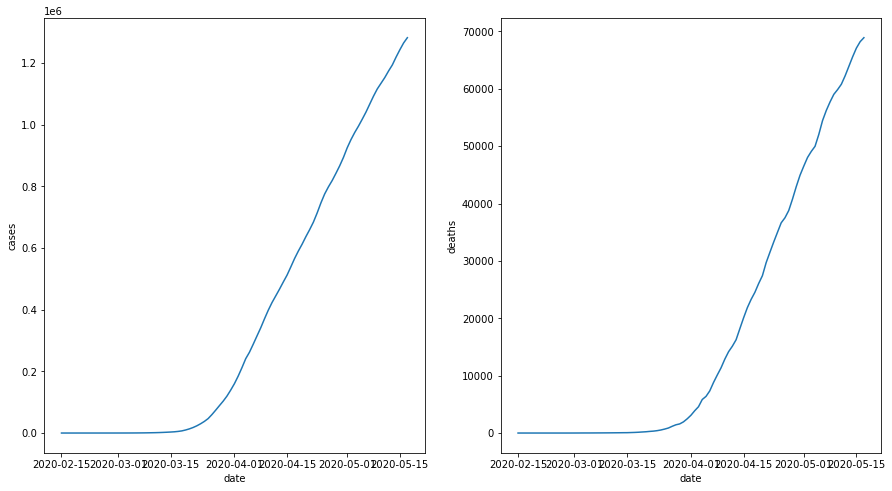

In [36]:
plt_data = full_data.groupby(['date'])['cases','deaths'].sum().reset_index()
f, ax = plt.subplots(1,2,sharex=True,figsize=(15,8))
sns.lineplot(x='date',y='cases',data=plt_data,ax=ax[0])
sns.lineplot(x='date',y='deaths',data=plt_data,ax=ax[1])


In [37]:
full_data.to_csv('data/compiled_{}.csv'.format(str(datetime.now().date())),index=False)

# Tracking Counties

In [40]:
orders = full_data[['state_x', 'state_abb_x', 'county_x','FIPS', 'soe','sah', 'state_ease_0', 'state_sah_0',
       'state_mandate_0', 'state_non_ess_0', 'state_lgb_0', 'state_sc_0',
       'state_bar_res_0', 'state_election_0', 'state_emergency_0',
       'state_compliance_0', 'state_prepare_0', 'state_ease_1',
       'state_sah_1', 'state_mandate_1', 'state_non_ess_1', 'state_lgb_1',
       'state_sc_1', 'state_bar_res_1', 'state_election_1',
       'state_emergency_1', 'state_compliance_1', 'state_prepare_1']].drop_duplicates()

orders.rename(columns={'state_x':'state', 'state_abb_x':'state_abb', 'county_x':'county'},inplace=True)
orders.to_csv('data/county_tracker.csv', index=False)

# Lag mobility data

In [37]:
full_data.columns.values

array(['country_region_code', 'country_region', 'state_x', 'county_x',
       'date', 'retail', 'food_drugs', 'park', 'transit', 'work', 'homes',
       'source', 'state_abb_x', 'FIPS', 'geo', 'POP_ESTIMATE_2018',
       'N_POP_CHG_2018', 'Births_2018', 'Deaths_2018', 'NATURAL_INC_2018',
       'INTERNATIONAL_MIG_2018', 'DOMESTIC_MIG_2018', 'NET_MIG_2018',
       'RESIDUAL_2018', 'GQ_ESTIMATES_2018', 'R_birth_2018',
       'R_death_2018', 'R_NATURAL_INC_2018', 'R_INTERNATIONAL_MIG_2018',
       'R_DOMESTIC_MIG_2018', 'R_NET_MIG_2018', 'POVALL_2018',
       'CI90LBAll_2018', 'CI90UBALL_2018', 'PCTPOVALL_2018',
       'CI90LBALLP_2018', 'CI90UBALLP_2018', 'POV017_2018',
       'CI90LB017_2018', 'CI90UB017_2018', 'PCTPOV017_2018',
       'CI90LB017P_2018', 'CI90UB017P_2018', 'POV517_2018',
       'CI90LB517_2018', 'CI90UB517_2018', 'PCTPOV517_2018',
       'CI90LB517P_2018', 'CI90UB517P_2018', 'MEDHHINC_2018',
       'CI90LBINC_2018', 'CI90UBINC_2018', 'POV04_2018', 'CI90LB04_2018',
     

In [58]:
full_data[full_data[['FIPS','date']].duplicated()]['FIPS']

1        NaN
3        NaN
5        NaN
7        NaN
9        NaN
          ..
127485   NaN
127486   NaN
127487   NaN
127488   NaN
127489   NaN
Name: FIPS, Length: 166, dtype: float64

# Weather Data from NOAA

In [3]:
fips_to_county = pd.read_csv('./data/ZIP-COUNTY-FIPS_2017-06.csv')
parks = pd.read_csv('./data/parks_only.csv')

In [4]:
fips_to_county[0:10]

,ZIP,COUNTYNAME,STATE,STCOUNTYFP,CLASSFP
0,36003,Autauga County,AL,1001,H1
1,36006,Autauga County,AL,1001,H1
2,36067,Autauga County,AL,1001,H1
3,36066,Autauga County,AL,1001,H1
4,36703,Autauga County,AL,1001,H1
5,36701,Autauga County,AL,1001,H1
6,36091,Autauga County,AL,1001,H1
7,36051,Autauga County,AL,1001,H1
8,36068,Autauga County,AL,1001,H1
9,36008,Autauga County,AL,1001,H1


In [71]:
fips = parks['FIPS'].unique()
len(fips)

956

In [72]:
fips_to_zips = dict()
for fip in fips:
    fips_to_zips[fip] = list(fips_to_county[fips_to_county['STCOUNTYFP']==fip]['ZIP'])

In [73]:
len(fips_to_zips)

956

In [6]:
dc_zips = county_to_zips['District of Columbia']
len(dc_zips)

219

In [7]:
def get_weather(locationid, datasetid, begin_date, end_date, mytoken, base_url):
    token = {'token': mytoken}
    
    #passing as string instead of dict because NOAA API does not like percent encoding
    params = 'datasetid='+str(datasetid)+'&'+'locationid='+str(locationid)+'&'+'startdate='+str(begin_date)+'&'+'enddate='+str(end_date)+'&'+'limit=25'+'&datatypeid=TOBS,PRCP'
    
    r = requests.get(base_url+params, headers=token)
    #print("Request status code: "+str(r.status_code))

    try:
        #results comes in json form. Convert to dataframe
        df = pd.DataFrame.from_dict(r.json()['results'])
        #print("Successfully retrieved "+str(len(df['station'].unique()))+" stations")
        dates = pd.to_datetime(df['date'])

        return df
    except:
        pass

In [65]:
import itertools
z = dict(itertools.islice(fips_to_zips.items(), 5))

In [45]:
import json
import pymongo
import time
from pprint import pprint

conn=pymongo.MongoClient()
db = conn.noaaweather
records = db.records
conn.list_database_names()

['admin', 'config', 'local', 'mydb', 'noaaweather']

In [59]:
records.delete_many({})

In [66]:
baseurl = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?'
mytoken = 'NVPWXeGxislWKqThiizoffNjnPtUtAcT'
databaseid = 'GHCND'
begindate = '2020-03-01'
enddate = '2020-05-01'

tic = time.perf_counter()
weather = pd.DataFrame()
for fip, codes in z.items():
    print(fip)
    fip_weather = pd.DataFrame()
    for code in codes:
        try:
            newdf = get_weather('ZIP:'+str(code), databaseid,begindate,enddate,mytoken,baseurl)
            fip_weather = fip_weather.append(newdf)
        except:
            continue
    #average across the county
    precip = fip_weather[fip_weather['datatype']=='PRCP'][['date','value']].rename(columns={'value':'precipitation'})
    temp = fip_weather[fip_weather['datatype']=='TOBS'][['date','value']].rename(columns={'value':'temp'})
    w = pd.merge(precip, temp, how ='outer', on ='date') 
    avgs = pd.merge(w.groupby('date', as_index=False)['precipitation'].mean(),
                    w.groupby('date', as_index=False)['temp'].mean(),on='date')
    avgs['FIPS']=fip
    avgs = avgs.to_dict()
    
    #insert records into MongoDB
    a = [{key:value[index] for key,value in avgs.items()}
         for index in range(max(map(len,avgs.values())))]
    records.insert_many(a)
    print(records.count())
    
toc= time.perf_counter()
print(f"Run time was {toc - tic:0.4f} seconds")

1001


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere


25
1003
62
1005
79
1007
124
1009
153
Run time was 429.0935 seconds
